In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
from sklearn import metrics
import seaborn as sns

In [2]:
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(1)

## Load the dataset

In [3]:
train_features = np.load('../Data/UTDMHAD_data/UTD_train_features.npy')
test_features = np.load('../Data/UTDMHAD_data/UTD_test_features.npy')
train_labels = np.load('../Data/UTDMHAD_data/UTD_train_labels.npy')
test_labels = np.load('../Data/UTDMHAD_data/UTD_test_labels.npy')

In [4]:
train_features.shape,  # 688   6 * 128

((688, 6, 128),)

#### Check the labels

In [5]:
train_labels[:100] # Label

array([ 7,  5, 11,  4, 12, 25, 25, 16,  1,  7, 15, 24,  7, 27, 16, 26, 18,
       10, 26, 24, 17, 21, 11, 14,  3,  5, 14,  9, 14, 12, 22, 15, 17,  5,
       14,  6, 17,  2, 15, 21, 17, 14, 14,  7, 19, 19, 27, 11, 25,  2,  7,
       14, 20, 15, 10, 18, 10, 16, 18, 14, 10, 22, 16, 25,  3, 26,  6, 27,
       13, 27,  5,  3, 23,  5,  2, 22,  3, 20, 26, 26, 16, 13,  8,  5,  6,
        1, 15,  7, 12, 15, 12,  5,  6,  1, 18, 11,  3, 19, 10, 14],
      dtype=int64)

#### Building loader
Images size = 6 * 128

In [6]:
tensor_train_features = torch.Tensor(train_features) # torch.Size([688, 6, 128])
tensor_train_labels = torch.Tensor(train_labels)
tensor_test_features = torch.Tensor(test_features) # torch.Size([173, 6, 128])
tensor_test_labels = torch.Tensor(test_labels)

# Add one dimension of channel
tensor_train_features = torch.unsqueeze(tensor_train_features, 1)# (torch.Size([688, 1, 6, 128]),)
tensor_test_features = torch.unsqueeze(tensor_test_features, 1)
train_dataset = TensorDataset(tensor_train_features, tensor_train_labels)
test_dataset = TensorDataset(tensor_test_features, tensor_test_labels)

In [7]:
tensor_train_features.shape, tensor_train_labels.shape, train_dataset

(torch.Size([688, 1, 6, 128]),
 torch.Size([688]),
 <torch.utils.data.dataset.TensorDataset at 0x1c401df2ac0>)

In [8]:
# Hyper parameter 
BATCH_SIZE = 16# 32 # 
EPOCHES = 10

#### 创建数据集的可迭代对象 Iratable object with batch

In [9]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = BATCH_SIZE, shuffle=True)

In [10]:
len(train_loader), len(test_loader)

(43, 11)

In [11]:
images,labels = next(iter(train_loader))
images.shape, labels.shape

(torch.Size([16, 1, 6, 128]), torch.Size([16]))

In [12]:
def imshow(inp):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean # Recovery the image
    inp = np.clip(inp, 0, 1) # clip the pixel between 0 and 1
    plt.imshow(inp)
    #if titlle is not None:
        #plt.title(title)
   

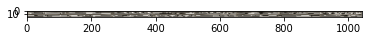

In [13]:
out = torchvision.utils.make_grid(images)
imshow(out)

In [14]:
# rnn
# num_feature = 6
# feature_width = 128
class RNN_model(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNN_model, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        #循环对象
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first = True, nonlinearity = "relu")
        
        #FC_layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0),self.hidden_dim).requires_grad_()#.to(device) 
        # X.SIZE = batch SIZE
        
        # 分离隐藏状态，避免梯度爆炸
        out, hn = self.rnn(x, h0.detach())# detach 分离
        out = self.fc(out[:, -1, :])# -1 the last layer state at time t
            
        return out
        
        
    

In [15]:
input_dim = 128 # input dimension
hidden_dim = 100 # hidden layers number
layer_dim = 2 
output_dim = 27 + 1 # output dimension

# initialize the model
model_rnn = RNN_model(input_dim, hidden_dim, layer_dim, output_dim)
# device = torch.device('cuda:0' if torch.cuda.is_available() else  'cpu')

#model = model.to(device)

In [16]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = torch.optim.SGD(model_rnn.parameters(), lr = learning_rate)

In [17]:
length = (len(list(model_rnn.parameters())))

In [18]:
for i in range(length):
    print("parameters: %d" %(i+1))
    print(list(model_rnn.parameters())[i].size())

parameters: 1
torch.Size([100, 128])
parameters: 2
torch.Size([100, 100])
parameters: 3
torch.Size([100])
parameters: 4
torch.Size([100])
parameters: 5
torch.Size([100, 100])
parameters: 6
torch.Size([100, 100])
parameters: 7
torch.Size([100])
parameters: 8
torch.Size([100])
parameters: 9
torch.Size([28, 100])
parameters: 10
torch.Size([28])


In [19]:
sequence_dim = 6
loss_list = []
accuracy_list = []
iteration_list = [] 
# 24576 = 32*1*6*128
iter =  0
for epoch in range(EPOCHES):
    for i, (images, labels) in enumerate(train_loader):
        model_rnn.train()
        # A batch of data with transfering the RNN input dimention 
        # 32*1*6*128
        images = images.view(-1, sequence_dim, input_dim).requires_grad_()#.to(device)
        labels = labels.to(torch.int64)
        #labels = labels.to(device)
        # gradient.zero
        optimizer.zero_grad()
        #forward pass
        output = model_rnn(images)

        
        # print(output.size(), labels.size(), "pass")
        # loss calc
        loss_rnn = criterion(output, labels)
        # backword
        loss_rnn.backward()
        # renew the parameter
        optimizer.step()
        
        iter += 1
        if iter % 10 == 0:
            model_rnn.eval()
            # accuracy
            correct = 0
            total = 0
            for i, (images, labels) in enumerate(train_loader):
                    images = images.view(-1, sequence_dim, input_dim)#.to(device)
                    outputs = model_rnn(images)
                    #print(outputs.size())
                    
                    predict = torch.max(outputs.data, 1)[1]
                    total += labels.size(0)
                    correct += (predict == labels).sum()
            
            accuracy = correct / total * 100
            loss_list.append(loss_rnn.data)
            accuracy_list.append(accuracy)
            iteration_list.append(iter)
            # print the info
            print("Iter:{},loss:{},Accuracy:{}".format(iter, loss_rnn.item(), accuracy))
            
            
          
                    
        

Iter:10,loss:107.51919555664062,Accuracy:4.069767475128174
Iter:20,loss:4.5404815673828125,Accuracy:3.488372325897217
Iter:30,loss:3.307569742202759,Accuracy:6.686046600341797
Iter:40,loss:3.171731472015381,Accuracy:8.284883499145508
Iter:50,loss:2.972853660583496,Accuracy:8.284883499145508
Iter:60,loss:3.297227382659912,Accuracy:8.720930099487305
Iter:70,loss:3.335211992263794,Accuracy:8.139534950256348
Iter:80,loss:2.9108974933624268,Accuracy:8.575581550598145
Iter:90,loss:2.524571418762207,Accuracy:8.866278648376465
Iter:100,loss:3.4872360229492188,Accuracy:7.848837375640869
Iter:110,loss:3.2838847637176514,Accuracy:6.976744651794434
Iter:120,loss:3.028318405151367,Accuracy:9.447674751281738
Iter:130,loss:3.161792755126953,Accuracy:7.412790298461914
Iter:140,loss:3.2699966430664062,Accuracy:8.575581550598145
Iter:150,loss:2.869600534439087,Accuracy:8.720930099487305
Iter:160,loss:3.3202123641967773,Accuracy:7.703488349914551
Iter:170,loss:2.8796329498291016,Accuracy:7.84883737564086

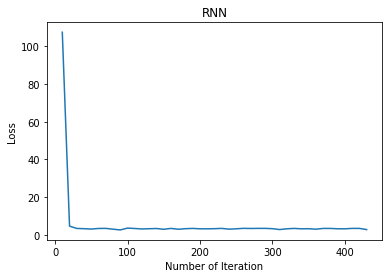

In [20]:
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of Iteration")
plt.ylabel("Loss")
plt.title("RNN")
plt.show()

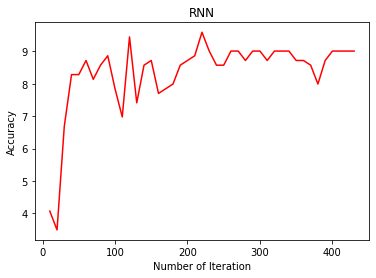

In [21]:
plt.plot(iteration_list,accuracy_list, color = "r")
plt.xlabel("Number of Iteration")
plt.ylabel("Accuracy")
plt.title("RNN")
plt.show()

In [22]:
labels = []
predictions = []
with torch.no_grad():
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(test_loader):
        images = images.view(-1, sequence_dim, input_dim)#.to(device)
        outputs = model_rnn(images)
        #print(outputs.size())
                    
        predict = torch.max(outputs.data, 1)[1]
        total += labels.size(0)
        correct += (predict == labels).sum()

    print('Test Accuracy of the basic RNN model on the UTD test features: {} %'.format((correct / total) * 100))

Test Accuracy of the basic RNN model on the UTD test features: 10.982658386230469 %


#### LSTM

In [23]:
class LSTM_model(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTM_model, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first = True)
        #FC_layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0),self.hidden_dim).requires_grad_()#.to(device) 
        c0 = torch.zeros(self.layer_dim, x.size(0),self.hidden_dim).requires_grad_()#.to(device) 
        # X.SIZE = batch SIZE
        
        # detach the hidden state to prevent exploding gradient
        out, (hn,cn) = self.lstm(x,( h0.detach(),c0.detach()))# detach 
        out = self.fc(out[:, -1, :])# -1 the last layer state at time t     
        return out

In [24]:
input_dim = 128 # input dimension
hidden_dim = 100 # hidden layers number
layer_dim = 1 
output_dim = 27 + 1 # output dimension

# initialize the model
model_lstm = LSTM_model(input_dim, hidden_dim, layer_dim, output_dim)
# device = torch.device('cuda:0' if torch.cuda.is_available() else  'cpu')

#model = model.to(device)

In [25]:
for i in range(len(list(model_lstm.parameters()))):
    print("parameters: %d" %(i+1))
    print(list(model_lstm.parameters())[i].size())

parameters: 1
torch.Size([400, 128])
parameters: 2
torch.Size([400, 100])
parameters: 3
torch.Size([400])
parameters: 4
torch.Size([400])
parameters: 5
torch.Size([28, 100])
parameters: 6
torch.Size([28])


In [26]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model_lstm.parameters(), lr = learning_rate)

In [27]:
sequence_dim = 6
lost_list_LSTM = []
accuracy_list = []
iteration_list = [] 
iter = 0

for epoch in range(EPOCHES):
    for i, (images, labels) in enumerate(train_loader):
        model_lstm.train()
        # 32*1*6*128
        images = images.view(-1, sequence_dim, input_dim).requires_grad_()#.to(device)
        labels = labels.to(torch.int64)
        #labels = labels.to(device)
        # gradient.zero
        optimizer.zero_grad()
        #forward pass
        
        outputs = model_lstm(images)
        # print(output.size(), labels.size(), "pass")
        # loss calc
        loss_lstm = criterion(outputs, labels)
        # backword
        loss_lstm.backward()
        # renew the parameter
        optimizer.step()
        
        iter += 1
        if iter % 10 == 0:
            model_lstm.eval()
            # accuracy
            correct = 0
            total = 0
            for i, (images, labels) in enumerate(train_loader):
                    images = images.view(-1, sequence_dim, input_dim)#.to(device)
                    outputs = model_lstm(images)
                    #print(outputs.size())
                    
                    predict = torch.max(outputs.data, 1)[1]
                    total += labels.size(0)
                    correct += (predict == labels).sum()
            
            accuracy = correct / total * 100
            lost_list_LSTM.append(loss_lstm.data)
            accuracy_list.append(accuracy)
            iteration_list.append(iter)
            # print the info
            print("Iter:{},loss:{},Accuracy:{}".format(iter, loss_lstm.item(), accuracy))
            
            


Iter:10,loss:3.1942291259765625,Accuracy:14.825580596923828
Iter:20,loss:3.0287842750549316,Accuracy:19.04069709777832
Iter:30,loss:2.948373794555664,Accuracy:26.453489303588867
Iter:40,loss:3.1656384468078613,Accuracy:25.436046600341797
Iter:50,loss:2.7939274311065674,Accuracy:30.668603897094727
Iter:60,loss:2.9890847206115723,Accuracy:31.686046600341797
Iter:70,loss:2.863940954208374,Accuracy:31.104650497436523
Iter:80,loss:2.733288288116455,Accuracy:32.41279220581055
Iter:90,loss:2.3044352531433105,Accuracy:37.5
Iter:100,loss:2.5310027599334717,Accuracy:38.953487396240234
Iter:110,loss:2.2080159187316895,Accuracy:37.645347595214844
Iter:120,loss:2.4249625205993652,Accuracy:40.406978607177734
Iter:130,loss:2.3884735107421875,Accuracy:41.569766998291016
Iter:140,loss:2.3875551223754883,Accuracy:41.13372039794922
Iter:150,loss:2.022825241088867,Accuracy:41.27906799316406
Iter:160,loss:2.5696356296539307,Accuracy:43.75
Iter:170,loss:2.6177611351013184,Accuracy:48.11046600341797
Iter:180

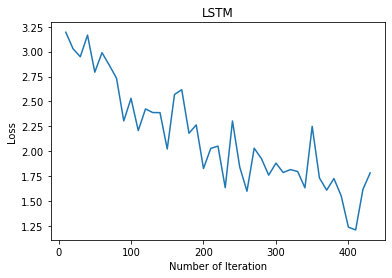

In [28]:
plt.plot(iteration_list,lost_list_LSTM)
plt.xlabel("Number of Iteration")
plt.ylabel("Loss")
plt.title("LSTM")
plt.show()

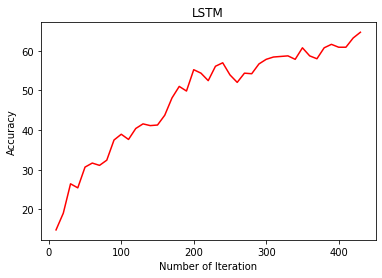

In [29]:
plt.plot(iteration_list,accuracy_list, color = "r")
plt.xlabel("Number of Iteration")
plt.ylabel("Accuracy")
plt.title("LSTM")
plt.show()

In [30]:
labels = []
predictions = []
with torch.no_grad():
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(test_loader):
        images = images.view(-1, sequence_dim, input_dim)#.to(device)
        outputs = model_lstm(images)
        #print(outputs.size())
                    
        predict = torch.max(outputs.data, 1)[1]
        total += labels.size(0)
        correct += (predict == labels).sum()
    
    print('Test Accuracy of the basic LSTM model on the UTD test features: {} %'.format((correct / total) * 100))

Test Accuracy of the basic LSTM model on the UTD test features: 53.17919158935547 %
